Tutorial with  first examples of how setting up an espresso  calculator and perform a Total Energy and bast structure calculations. 

1. Setting up the system.  

In [60]:
from ase import Atoms
from ase.lattice import FCC
from ase.visualize import  view

si_fcc = Atoms(symbols='Si2',
               cell = FCC(a=10.20 * 0.529177).tocell(),
               scaled_positions=[(0.0, 0.0, 0.0),
                                 (0.25, 0.25, 0.25)],
               pbc=True)


setup basic PW calculator for scf calculation:

1. The main input variables: 

In [61]:
from pathlib import Path
pseudo_dir = str(Path.home() / 'qe-7.2/pseudo/')
control = {'calculation': "scf",
           'prefix': "si_fcc",
           'pseudo_dir': pseudo_dir,
           'tprnfor': True,
           'tstress': True}
system = {'ecutwfc': 35.00}
electrons = {'diagonalization':'davidson',
             'conv_thr': 1.e-8}

2. The pseudopotentials for each atomic species
2. The MP mesh for kpoints 
2. The offset of the MP mesh 
2. The command for starting the calculations 

In [62]:
atomic_species = {'Si':'Si.pz-vbc.UPF'}
kpts = [8,8,8] #8X8X8 MP k-point mesh 
koffset = [0,0,0] 


6. set pw command. For the correct interaction with the ase calculator:
    * the input file must be `{label}.pwi`
    * the output file must be `{label}.pwo` 

In [63]:

def pwcommand (label='scf'): 
    from pathlib import Path
    qepath = str(Path.home() / 'qe-7.2/bin/')
    return f"mpirun -np 4 {qepath}/pw.x -i {label}.pwi > {label}.pwo" 

In [64]:
pwcommand('scf')

'mpirun -np 4 /home/pietro/qe-7.2/bin/pw.x -i scf.pwi > scf.pwo'

In [65]:
from ase.calculators.espresso import Espresso as QEpw
scf_calc = QEpw(label='scf',
                command = pwcommand('scf'),
                input_data={'control': control,
                            'system': system,
                            'electrons': electrons},
                pseudopotentials=atomic_species,
                kpts=[8,8,8],
                koffset=[1,1,1])


In [66]:
si_fcc.calc = scf_calc
si_fcc.get_properties(['energy'])

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


(Properties({'energy': -215.69011555407923, 'free_energy': -215.69011555407923, 'natoms': 2, 'forces': array([[ 0.,  0., -0.],
       [-0., -0.,  0.]]), 'stress': array([-0.00065006, -0.00065006, -0.00065006,  0.        ,  0.        ,
        0.        ])})

Setup the calculator for computing the bands. 
1. First we generate the k-point path using ASE bandpath method:

In [67]:
kpointpath = si_fcc.cell.bandpath(path='LGXWKG', density=20)
kpointpath.special_points

{'G': array([0., 0., 0.]),
 'K': array([0.375, 0.375, 0.75 ]),
 'L': array([0.5, 0.5, 0.5]),
 'U': array([0.625, 0.25 , 0.625]),
 'W': array([0.5 , 0.25, 0.75]),
 'X': array([0.5, 0. , 0.5])}

7. Then we setup the new calculator for bands:

In [68]:
control.update({'calculation':"bands"})
system.update({'nbnd':8})
electrons.update({'conv_thr': 1.e-6})
bands_calc = QEpw(label='bands',
                  input_data={'control': control,
                              'system': system,
                              'electrons':electrons},
                  pseudopotentials=atomic_species, 
                  command=pwcommand(label='bands'),
                  kpts=kpointpath) 


8. We run the bands calcuation with the new calculator. 

In [69]:
bands_calc.calculate(si_fcc)

In [70]:
bands_structure = bands_calc.band_structure()
bands_structure._reference = si_fcc.calc.get_fermi_level() 



<Axes: ylabel='energies [eV]'>

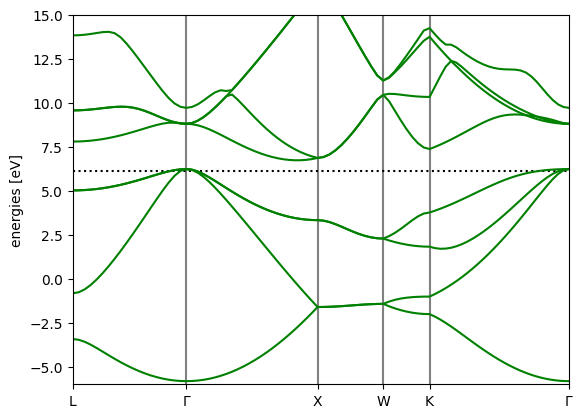

In [71]:
bands_structure.plot(emin=-6, emax=15)

Now we setup the calcutator for computing the DOS, in this case we will perform first an nscf calculation with a symmetrized, denser  MP grid. 

In [72]:
control.update({'calculation':'nscf',
                'verbosity': 'high'})
nscf_calc = QEpw(label='nscf',
                 command= pwcommand(label='nscf'),
                 input_data={'control': control,
                             'system': system,
                             'electron': electrons}, 
                 pseudopotentials=atomic_species, 
                 kpts=[16,16,16],
                 koffset=[0,0,0]) 
                            
nscf_calc.calculate(si_fcc)

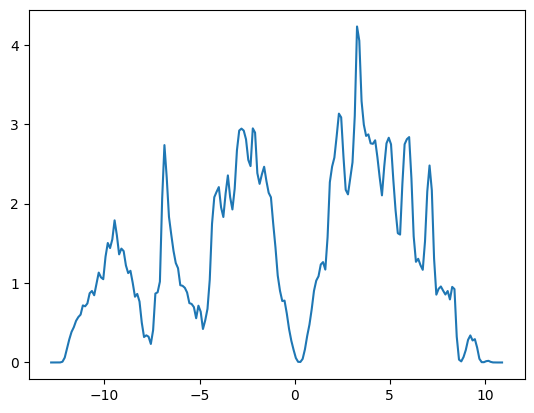

In [73]:
from ase.dft.dos import DOS 
from matplotlib  import pyplot as plt

dos = DOS(nscf_calc, npts = 200,width=0.15) 
energies=dos.get_energies() 
dosvals = dos.get_dos() 
plt.plot(energies, dosvals)
plt.show()